# Stima infetti reali

Stima infetti reali con fast backcasting.

> Max Pierini

***

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as sc
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import display, Markdown

In [2]:
def dist_params(mu, sd, ax, parname, pct=False):
    dist = sps.norm(loc=mu, scale=sd)
    x1 = np.linspace(dist.ppf(.025), dist.ppf(.975))
    y1 = dist.pdf(x1)
    x2 = np.linspace(dist.ppf(.001), dist.ppf(.999))
    y2 = dist.pdf(x2)
    ax.plot(x1, y1, lw=7, label='95% CI')
    ax.plot(x2, y2)
    ax.plot([mu-sd, mu+sd], [0, 0], lw=4, label='SD')
    ax.axvline(mu, color='r', ls='--', label='mean')
    ax.axhline(0, color='k', alpha=.25)
    ax.set(
        title=parname,
        yticks=[],
    )
    if pct:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))

In [3]:
def define_parameters(n_size,
                      cov1 = 0.86,
                      cov2 = 0.45,
                      dt_incub_lo = 4.1,
                      dt_incub_hi = 7.0,
                      dt_onset_lo = 12.8,
                      dt_onset_hi = 19.2,
                      ifr_lo = 2.03 / 100,
                      ifr_hi = 2.45 / 100,
                      ci=.95,
                      plot_params=False
                     ):

    # compute min and max C.I.
    ci_lo = (1 - ci) / 2
    ci_hi = 1 - ci_lo
    gauss_lo = sps.norm.isf(ci_lo)
    gauss_hi = sps.norm.isf(ci_hi)
    
    # compute means
    dt_incub_mu = 0.5 * (dt_incub_lo + dt_incub_hi)
    dt_onset_mu = 0.5 * (dt_onset_lo + dt_onset_hi)
    ifr_mu = 0.5 * (ifr_lo + ifr_hi)
    
    # compute standard deviations for given ci
    dt_incub_sd = (dt_incub_hi - dt_incub_lo) / (gauss_lo - gauss_hi)
    dt_onset_sd = (dt_onset_hi - dt_onset_lo) / (gauss_lo - gauss_hi)
    ifr_sd = (ifr_hi - ifr_lo) / (gauss_lo - gauss_hi)

    if plot_params:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        for mu, sd, ax, par in zip([ifr_mu, dt_incub_mu, dt_onset_mu],
                                   [ifr_sd, dt_incub_sd, dt_onset_sd],
                                   [axs[0], axs[1], axs[2]],
                                   ['IFR', 'incubation period', 'onset-to-death']
                                  ):
            pct = False
            if par == 'IFR':
                pct = True
            dist_params(mu, sd, ax, par, pct=pct)
            ax.legend()
        plt.show()
    
    # min and max params for infection to death
    #dt_death_lo = dt_incub_lo + dt_onset_lo
    #dt_death_mu = dt_incub_mu + dt_onset_mu
    #dt_death_hi = dt_incub_hi + dt_onset_hi

    dt_df = pd.DataFrame({
        'incub': [dt_incub_lo, dt_incub_mu, dt_incub_hi],
        'onset': [dt_onset_lo, dt_onset_mu, dt_onset_hi],
        'IFR': [ifr_lo, ifr_mu, ifr_hi],
    }, index=['lo', 'mu', 'hi'])
    # min, mean and max for onset to death
    dt_df['death'] = dt_df.incub + dt_df.onset
    # compute parameters for gamma distributions
    dt_df['incub_sd'] = dt_df.incub * cov1
    dt_df['onset_sd'] = dt_df.onset * cov2
    dt_df['death_sd'] = np.sqrt(dt_df.incub_sd**2 + dt_df.onset_sd**2)
    dt_df['_cov_'] = dt_df.death_sd / dt_df.death
    dt_df['alpha'] = 1.0 / dt_df._cov_**2
    dt_df['beta'] = dt_df.death * dt_df._cov_**2
    # gamma distributions
    dt_dist = sps.gamma(
        a=dt_df.alpha.values.reshape(-1, 1), 
        scale=dt_df.beta.values.reshape(-1, 1)
    )
    gamma_x = np.arange(n_size)
    # probability density functions
    PDFs = dt_dist.pdf(gamma_x)
    PDFs[0,:] /= PDFs[0,:].sum()
    PDFs[1,:] /= PDFs[1,:].sum()
    PDFs[2,:] /= PDFs[2,:].sum()
    # cumulative density functions
    CDFs = PDFs.cumsum(axis=1)
    CDFs[0,:] /= CDFs[0,:].max()
    CDFs[1,:] /= CDFs[1,:].max()
    CDFs[2,:] /= CDFs[2,:].max()
    
    return (dt_df, PDFs, CDFs, gamma_x)

In [4]:
def backcasting(d_omega, AWRs, PDFs, CDFs, index):
    
    size = d_omega.size
    
    d_alpha_raw = np.ndarray(shape=(9, size))
    d_alpha_cor = np.ndarray(shape=(9, size))
    
    # TODO: -1 ?
    for i_alpha in range(size):
        # define observed omega events
        i_omega_0 = i_alpha
        i_omega_T = size
        d_omega_obs = d_omega[i_omega_0:i_omega_T]
        # define last index for PDF of omega events
        i_PDF_T = size - i_omega_0
        #i_CDF = size - 1 - i_alpha
        #print(i_alpha, i_PDF_T, i_CDF)
        # loop through PDFs
        for i, PDF in enumerate(PDFs):
            pdf = PDF[0:i_PDF_T]
            #cdf = CDFs[i][i_CDF]
            cdf = CDFs[i][::-1][i_alpha]
            #print(i_alpha, cdf)
            # loop through AWRs
            for j, AWR in enumerate(AWRs):
                __alpha_raw_series = pdf * d_omega_obs / AWR
                __alpha_raw = np.sum(__alpha_raw_series)
                #__alpha_cor_series = (pdf / cdf) * (d_omega_obs / AWR)
                old_settings = np.seterr(all='ignore')
                __alpha_cor = __alpha_raw / cdf
                _ = np.seterr(**old_settings)
                d_alpha_raw[i*3+j,i_alpha] = __alpha_raw
                d_alpha_cor[i*3+j,i_alpha] = __alpha_cor

    d_alpha_raw_df = pd.DataFrame({
            'lo': np.ceil(np.percentile(d_alpha_raw, 2.5, axis=0)),
            'mu': np.median(d_alpha_raw, axis=0),
            'hi': np.floor(np.percentile(d_alpha_raw, 97.5, axis=0)),
        }, index=index
    )
    d_alpha_raw_df.dropna(inplace=True)
    
    d_alpha_cor_df = pd.DataFrame({
            'lo': np.ceil(np.percentile(d_alpha_cor, 2.5, axis=0)),
            'mu': np.median(d_alpha_cor, axis=0),
            'hi': np.floor(np.percentile(d_alpha_cor, 97.5, axis=0)),
        }, index=index
    )
    d_alpha_cor_df.dropna(inplace=True)
    
    c_alpha_raw_df = d_alpha_raw_df.cumsum(axis=0)
    c_alpha_cor_df = d_alpha_cor_df.cumsum(axis=0)
    
    d_alpha_adj_df = (d_alpha_raw_df + d_alpha_cor_df) / 2
    d_alpha_adj_df.dropna(inplace=True)
    c_alpha_adj_df = d_alpha_adj_df.cumsum(axis=0)
    
    res = {
        'c_alpha_raw': c_alpha_raw_df,
        'd_alpha_raw': d_alpha_raw_df,
        'c_alpha_cor': c_alpha_cor_df,
        'd_alpha_cor': d_alpha_cor_df,
        'c_alpha_adj': c_alpha_adj_df,
        'd_alpha_adj': d_alpha_adj_df,
    }
    
    return res

# ITALIA

In [5]:
df = pd.read_csv(
    "https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/"
    "dpc-covid19-ita-andamento-nazionale.csv",
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [6]:
prev_dt_range = pd.date_range(
    pd.to_datetime('2020-01-01'),
    df.index[0] - pd.Timedelta(days=1)
)
prev_DPC = pd.DataFrame(columns=df.columns, index=prev_dt_range)

prev_DPC.loc[:,:] = 0

DF = prev_DPC.append(df)

DF['nuovi_deceduti'] = DF.deceduti.diff()
DF.loc[DF.nuovi_deceduti<0, 'nuovi_deceduti'] = np.nan

DF.fillna(0, inplace=True)

In [7]:
n_dfat = DF.nuovi_deceduti.values.ravel()

In [8]:
par_df2, PDFs2, CDFs2, xDF2 = define_parameters(
    n_dfat.size,
    ci=.95,
)

In [9]:
res2 = backcasting(
    n_dfat, par_df2.IFR.values, PDFs2, CDFs2, DF.index,
)

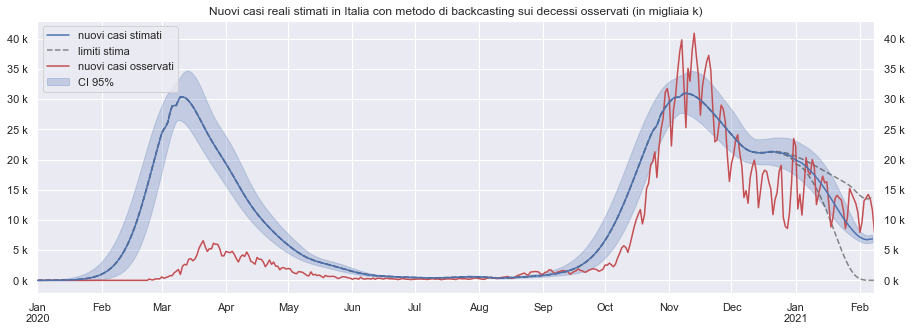

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
res2['d_alpha_adj'].mu.plot(ax=ax, zorder=100, color='C0', label='nuovi casi stimati')
#
ax.plot(res2['d_alpha_raw'].mu, color='k', alpha=.5, ls='--', label='limiti stima')
ax.plot(res2['d_alpha_cor'].mu, color='k', alpha=.5, ls='--')
#.plot(ax=ax, 
#res2['d_alpha_cor'].mu.plot(ax=ax, color='C1', label=None, legend=False)
#ax.fill_between(
#    res2['d_alpha_cor'].index,
#    res2['d_alpha_raw'].lo[:-1],
#    res2['d_alpha_cor'].hi,
#    alpha=.1, color='k',
#
#)
#
ax.fill_between(
    res2['d_alpha_adj'].index,
    res2['d_alpha_adj'].lo, res2['d_alpha_adj'].hi,
    alpha=.25, label='CI 95%', color='C0'
)
DF.plot(y='nuovi_positivi', ax=ax, color='r', label='nuovi casi osservati')
ax.legend(loc='upper left')
ax.legend(loc='upper left')
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.0f} k" for i in ax.get_yticks()/1e3],
)
ax.set(
    title="Nuovi casi reali stimati in Italia con metodo di backcasting sui decessi osservati"
    " (in migliaia k)",
    ylim=ylim,
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
plt.show()

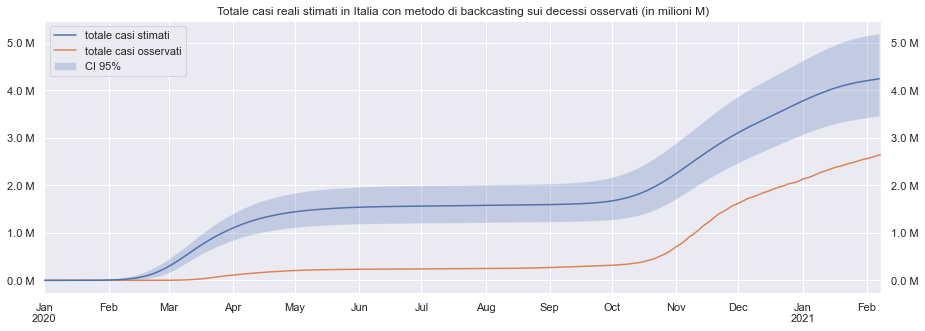

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
res2['c_alpha_adj'].mu.plot(ax=ax, label='totale casi stimati', zorder=100)
ax.fill_between(
    res2['c_alpha_adj'].index,
    res2['c_alpha_adj'].lo, res2['c_alpha_adj'].hi,
    alpha=.25, label='CI 95%'
)
#
#ax.plot(res2['c_alpha_raw'].mu, color='k', alpha=.5, ls='--', label='limiti stima')
#ax.plot(res2['c_alpha_cor'].mu, color='k', alpha=.5, ls='--')
#
DF.plot(y='totale_casi', ax=ax, label='totale casi osservati')
ax.legend(loc='upper left')
ylim = ax.get_ylim()
ax.set(
    yticks=ax.get_yticks(),
    yticklabels=[f"{i:.1f} M" for i in ax.get_yticks()/1e6],
)
ax.set(
    title="Totale casi reali stimati in Italia con metodo di backcasting sui decessi osservati"
    " (in milioni M)",
    ylim=ylim,
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
plt.show()

Possiamo definire il tasso di rilevamento $\mathrm{DR}_t$ (Detection Rate) al tempo $t$ come la percentuale di eventi $n(\hat{\alpha}_t)$ stimati sugli eventi $n(\alpha_t)$ osservati in $t$

$$
\mathrm{DR}_t = \frac{
    \sum_{i=0}^{t} n(\hat{\alpha_i})
}{
    \sum_{i=0}^{t} n(\alpha_i)
}
$$

Un $\mathrm{DR}_t$ pari al 100% significa che tutti i casi vengono correttamente rilevati. Al contrario un $\mathrm{DR}_t$ minore del 100% significa che una parte dei casi, ovvero $1-\mathrm{DR}_t$, sfuggono al rilevamento.

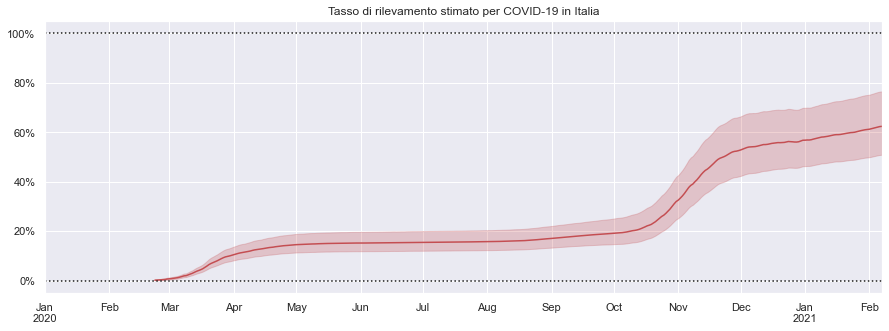

In [12]:
c_det_rate_adj_2 = DF.totale_casi.replace(0, np.nan).values[1:].reshape(-1, 1) / res2['c_alpha_adj']

#c_det_rate_raw_2 = DF.totale_casi.replace(0, np.nan).values.reshape(-1, 1) / res2['c_alpha_raw']
#c_det_rate_cor_2 = DF.totale_casi.replace(0, np.nan).values[1:].reshape(-1, 1) / res2['c_alpha_cor']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set(
    title='Tasso di rilevamento stimato per COVID-19 in Italia'
)
c_det_rate_adj_2.mu.plot(ax=ax, color='r')
ax.fill_between(
    c_det_rate_adj_2.index,
    c_det_rate_adj_2.lo, c_det_rate_adj_2.hi,
    alpha=.25, color='r',
    label='CI 95%'
)
#
#ax.plot(c_det_rate_raw_2.mu, color='k', alpha=.5, ls='--', label='limiti stima')
#ax.plot(c_det_rate_cor_2.mu, color='k', alpha=.5, ls='--')
#

ax.axhline(1, color='k', ls=':')
ax.axhline(0, color='k', ls=':')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

In [13]:
display(Markdown(f"""
L'attuale $\mathrm{{DR}}_t$ stimato è quindi pari a
{c_det_rate_adj_2.mu.values[-1]:.1%}
(95% CI: {c_det_rate_adj_2.hi.values[-1]:.1%}, {c_det_rate_adj_2.lo.values[-1]:.1%}),
ovvero si stima che
il **{1-c_det_rate_adj_2.mu.values[-1]:.1%} dei
casi sarebbe sfuggito al rilevamento**
(95% CI: {1-c_det_rate_adj_2.lo.values[-1]:.1%}, {1-c_det_rate_adj_2.hi.values[-1]:.1%}).
"""))


L'attuale $\mathrm{DR}_t$ stimato è quindi pari a
62.3%
(95% CI: 50.9%, 76.5%),
ovvero si stima che
il **37.7% dei
casi sarebbe sfuggito al rilevamento**
(95% CI: 23.5%, 49.1%).


Dal grafico dei nuovi casi e del tasso di rilevamento, notiamo che la maggior parte dei mancati rilevamenti è avvenuta nella prima fase della curva epidemica, indicativamente tra Febbraio e Giugno. In seguito, verosimilmente grazie alle campagne di screening e contact-tracing, la differenza tra casi reali (stimati) e osservati risulta molto meno marcata.

# METODO

In [14]:
test_size = 60*4

In [15]:
par_df1, PDFs1, CDFs1, xDF1 = define_parameters(
    test_size,
    cov1 = 0.86,
    cov2 = 0.45,
    dt_incub_lo = (4.1 + 7.0) / 2,
    dt_incub_hi = (4.1 + 7.0) / 2,
    #dt_incub_lo = 4.1,
    #dt_incub_hi = 7.0,
    dt_onset_lo = (12.8 + 19.2) / 2,
    dt_onset_hi = (12.8 + 19.2) / 2,
    #dt_onset_lo = 12.8,
    #dt_onset_hi = 19.2,
    ifr_lo = (5.75 + 6.25) / 2 / 100,
    ifr_hi = (5.75 + 6.25) / 2 / 100,
    #ifr_lo = 5.75 / 100,
    #ifr_hi = 6.25 / 100,
    ci=.95,
)

In [16]:
def generate_cases(L, k, n_days=60*4, x0=60*2, start=0):
    x = np.arange(n_days)
    return x, (L / (1 + np.exp(-k * (x - x0)))).astype(int)

In [17]:
X, Y = generate_cases(L=1e6, k=.05, n_days=test_size, x0=60*2.75)

In [18]:
Z = np.zeros(test_size)
Z[int(par_df1.death.mu):] = Y[:-int(par_df1.death.mu)] * par_df1.IFR.mu

## Concetto di backcasting

Il metodo di fast backcasting di EpiData.it si basa sul backcasting per simulazione Monte Carlo di [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909) ma implementato per esecuzione veloce senza uso di simulazioni.

Siano dati due eventi $\alpha$ e $\omega$.

Sia definita Alpha-Omega-Rate $\mathrm{A}\Omega\mathrm{R}$ la probabilità condizionata non nulla del verificarsi dell'evento $\omega$ in seguito all'osservazione dell'evento $\alpha$

$$
P(\omega | \alpha) = \mathrm{A}\Omega\mathrm{R} \;\,\; >0
$$

Sia posta pari a 1 la probabilità condizionata che si sia verificato $\alpha$ data l'osservazione di un evento $\omega$

$$
P(\alpha | \omega) = 1
$$

ovvero

- l'evento $\omega$ ha probabilità $\mathrm{A}\Omega\mathrm{R}$ di accadere in seguito ad un evento $\alpha$

- l'osservazione di un evento $\omega$ comporta sicuramente l'accadimento di un evento $\alpha$ nel passato

Pertanto, data l'osservazione di $n(\omega)$ eventi $\omega$, si può stimare che il numero $n(\alpha)$ di eventi $\alpha$ occorsi sia

$$
n(\alpha) = \frac{n(\omega)}{\mathrm{A}\Omega\mathrm{R}}
$$

Sia data una distribuzione di probabilità $p(\omega_{t_0 + \tau})$ nel tempo $t$ del verificarsi dell'evento $\omega_{t_0+\tau}$ dopo $\tau$ unità di tempo dall'osservazione dell'evento $\alpha_{t_0}$ al tempo $t_0$

$$
p(\omega_{t_0 + \tau}) = \mathbf{PDF}[\omega]_{t_0 + \tau}
$$

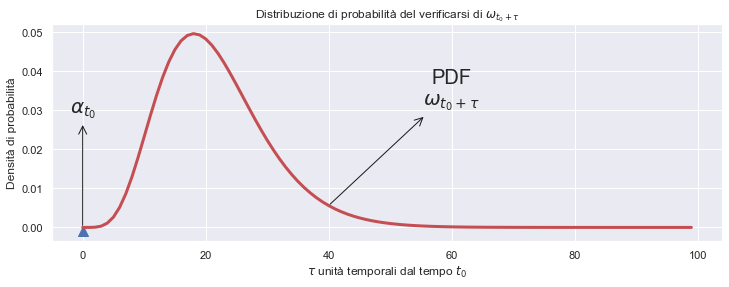

In [19]:
x_lim = 100

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[:x_lim], PDFs1[2,:x_lim], lw=3, color='r')
ax.scatter(0, -0.001, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dal tempo $t_0$",
    ylabel="Densità di probabilità",
    title=r"Distribuzione di probabilità del verificarsi di $\omega_{t_0 + \tau}$"
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(0, 0),
    xytext=(0, .03),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "PDF\n"r"$\omega_{t_0 + \tau}$",
    xy=(40, PDFs1[2,40]),
    xytext=(60, .035),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Noto il numero $n(\omega_t)$ di eventi $\omega$ nel tempo $t$, possiamo stimare che il numero $n(\alpha_{t_0})$ di eventi $\alpha$ occorsi in $t_0<t$ siano pari alla somma degli eventi $n(\omega_{t_0 + \tau})$ moltiplicati per la densità di probabilità $\mathbf{PDF}[\omega]_{t_0 + \tau}$ al tempo $t_0 + \tau$ divisa per la probabilità condizionata $p(\omega|\alpha)$

$$
n(\alpha_{t_0}) = \sum_{\tau=1}
\frac{
    n(\omega_{t_0 + \tau})
}{
    \mathrm{A}\Omega\mathrm{R}
} \mathbf{PDF}[\omega]_{t_0 + \tau}
$$

Indicando con $t=T$ l'ultimo giorno di osservazione, possiamo affermare che soprattutto negli ultimi giorni della serie temporale, il numero di eventi $n(\alpha)$ sarà ovviamente sottostimato perché i futuri eventi $\omega$, di cui potrebbero essere causa, non sono ancora accaduti.

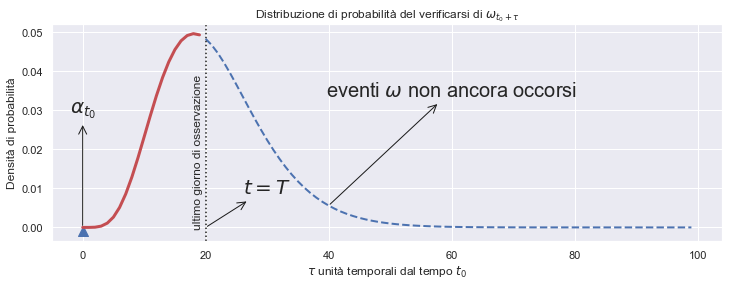

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[:20], PDFs1[2,:20], lw=3, color='r')
ax.plot(xDF1[20:x_lim], PDFs1[2,20:x_lim], lw=2, ls='--', color='b')
ax.axvline(20, ls=':', color='k')
ax.scatter(0, -0.001, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dal tempo $t_0$",
    ylabel="Densità di probabilità",
    title=r"Distribuzione di probabilità del verificarsi di $\omega_{t_0 + \tau}$"
)
ax.text(
    19.5, 0,
    'ultimo giorno di osservazione',
    rotation=90, ha='right'
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(0, 0),
    xytext=(0, .03),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "eventi $\omega$ non ancora occorsi",
    xy=(40, PDFs1[2,40]),
    xytext=(60, .035),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "$t=T$",
    xy=(20, 0),
    xytext=(30, .01),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Supponiamo, ad esempio, di avere i seguenti dati:

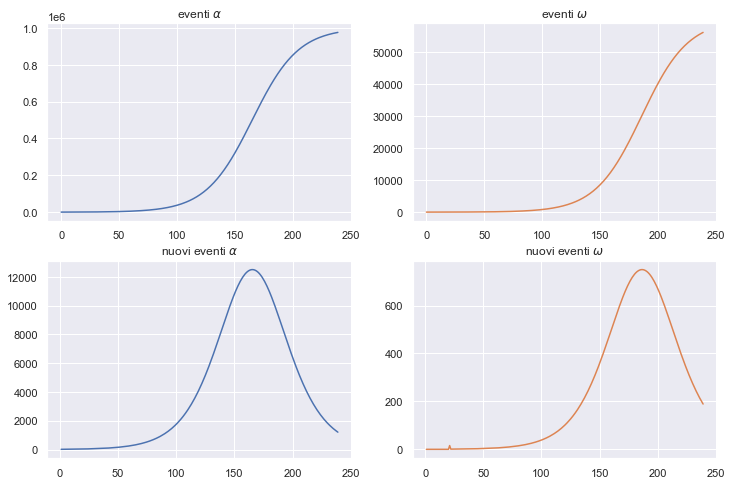

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].plot(X, Y)
ax[0,0].set(
    title=r'eventi $\alpha$'
)

ax[0,1].plot(X, Z, color='C1')
ax[0,1].set(
    title=r'eventi $\omega$'
)

ax[1,0].plot(X[1:], np.diff(Y))
ax[1,0].set(
    title=r'nuovi eventi $\alpha$'
)

ax[1,1].plot(X[1:], np.diff(Z), color='C1')
ax[1,1].set(
    title=r'nuovi eventi $\omega$'
)


plt.show()

Vogliamo stimare il numero di eventi $n(\alpha)$ con metodo di backcasting dagli eventi $\omega$ noti e sapendo che la probabilità di osservare $\omega$ in conseguenza di $\alpha$ nel tempo $t$ è una distribuzione **Gamma** con i seguenti parametri di _shape_ e _scale_ (_scale_ è definita come 1/_rate_) e il seguente $\mathrm{A} \Omega \mathrm{R}$

In [61]:
t_df = par_df1[['IFR', 'alpha', 'beta']].loc[['mu']].copy(deep=True)
t_df.columns = ['AΩR', 'shape', 'scale']
t_df.index = ['value']
t_df.style.format(
    formatter={'AΩR': "{:.2%}"}
).set_caption("AΩR and Gamma parameters")

,AΩR,shape,scale
value,6.00%,6.223439,3.462716


In [23]:
res1 = backcasting(
    np.concatenate(([0], np.diff(Z))), par_df1.IFR.values, PDFs1, CDFs1, range(Z.size),
)

Notiamo la sottostima nell'ultima parte della serie temporale dovuta agli eventi $\omega$ non ancora occorsi e la "caduta a zero" dei nuovi eventi $\alpha$ stimati in $t=T$: per l'ultimo giorno della serie temporale non si ha alcun dato futuro da cui stimare i probabili eventi $\alpha$.

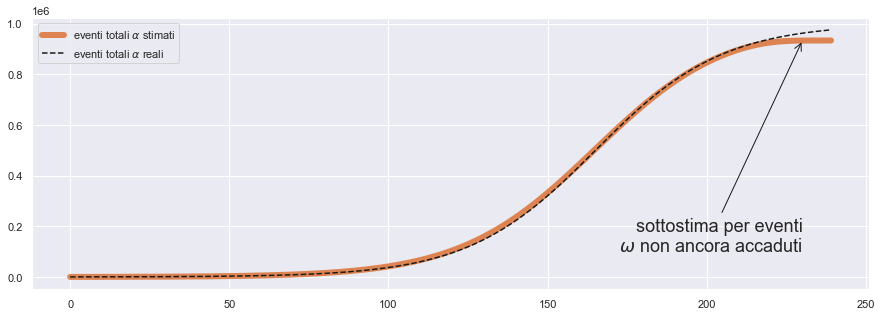

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_raw'].mu.plot(ax=ax, label=r'eventi totali $\alpha$ stimati', color='C1', lw=6)
ax.plot(X, Y, color='k', ls='--', label=r'eventi totali $\alpha$ reali', zorder=100)
ax.annotate(
    'sottostima per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(230, res1['c_alpha_raw'].mu.values[230]),
    xytext=(230, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend()
plt.show()

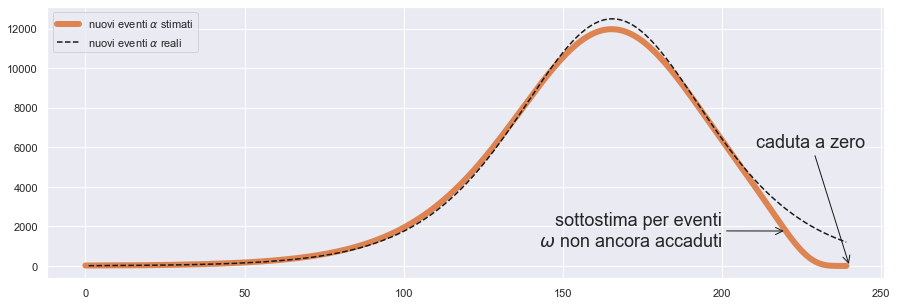

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_raw'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati', color='C1', lw=6)
ax.plot(X[1:], np.diff(Y), color='k', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'sottostima per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(220, res1['d_alpha_raw'].mu.values[220]),
    xytext=(200, 1e3),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.annotate(
    'caduta a zero',
    xy=(240, res1['d_alpha_raw'].mu.values[239]),
    xytext=(245, 6e3),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)

ax.legend(loc='upper left')
plt.show()

## Correzione temporale

Nota la distribuzione di probabilità del verificarsi dell'evento $\omega$ in seguito ad $\alpha$ nel tempo $t$ e indicato con $t=T$ l'ultimo giorno di osservazione, la probabilità $p(\alpha|\omega)_{t_0}$ di aver osservato tutti gli eventi $\omega$ causati dagli eventi $\alpha$ nel tempo $[t_0...T]$ è esprimibile come la densità di probabilità cumulativa di $\omega$ al tempo $t=T-t_0$

$$
p(\alpha|\omega)_{t_0} = \mathbf{CDF}[\omega]_{T-t_0}
$$

possiamo perciò correggere il numero di eventi $n(\alpha_{t_0})$ stimati dividendo per la probabilità $p(\alpha|\omega)_{t_0}$

$$
n(\alpha_{t_0}) = \sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
\frac{
    \mathbf{PDF}[\omega]_{t_0+\tau}
}{
    \mathbf{CDF}[\omega]_{T-t_0}
}
$$

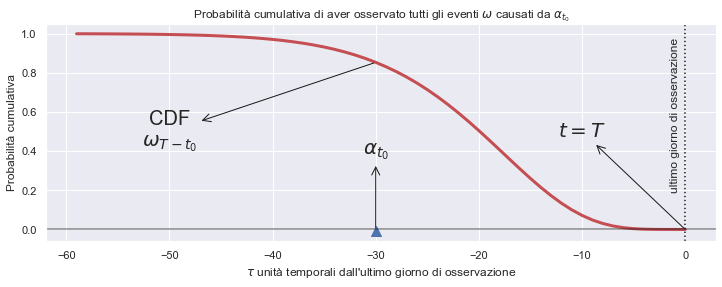

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xDF1[-60:]-test_size+1, CDFs1[2,::-1][-60:], lw=3, color='r')
ax.axhline(0, color='k', alpha=.5)
ax.axvline(0, ls=':', color='k')
ax.scatter(-30, -.01, marker='^', s=100)
ax.set(
    xlabel=r"$\tau$ unità temporali dall'ultimo giorno di osservazione",
    ylabel="Probabilità cumulativa",
    title=r"Probabilità cumulativa di aver osservato tutti gli eventi $\omega$ causati da $\alpha_{t_0}$"
)
ax.text(
    -.5, .2,
    'ultimo giorno di osservazione',
    rotation=90, ha='right'
)
ax.annotate(
    r"$\alpha_{t_0}$",
    xy=(-30, 0),
    xytext=(-30, .4),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    r"$t=T$",
    xy=(0, 0),
    xytext=(-10, .5),
    ha='center', va='center',
    fontsize=20,
    arrowprops=dict(color='k', arrowstyle='<-')
)
ax.annotate(
    "CDF\n$\omega_{T-t_0}$",
    xy=(-30, CDFs1[2,::-1][-31]),
    xytext=(-50, .5),
    ha='center', va='center',
    fontsize=20,
   arrowprops=dict(color='k', arrowstyle='<-')
)
plt.show()

Notiamo che nonostante la correzione abbia evitato la "caduta a zero" dei nuovi eventi $\alpha$ e la sottostima, ora siamo di fronte ad una sovrastima: la correzione effettuata non è in grado di "prevedere" i futuri eventi $\omega$ ma solamente di stimare la probabilità di aver osservato in $t_0$ tutti gli eventi $\omega$ causati da $\alpha$.

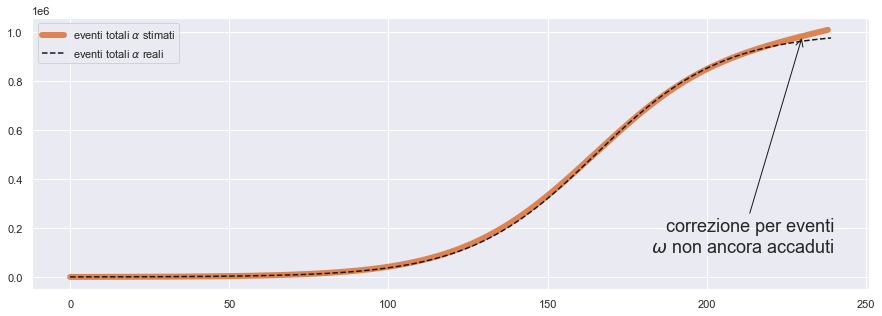

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_cor'].mu.plot(ax=ax, label=r'eventi totali $\alpha$ stimati', color='C1', lw=6)
ax.plot(X, Y, color='k', ls='--', label=r'eventi totali $\alpha$ reali')
ax.annotate(
    'correzione per eventi\n'r'$\omega$ non ancora accaduti',
    xy=(230, res1['c_alpha_cor'].mu.values[230]),
    xytext=(240, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend()
plt.show()

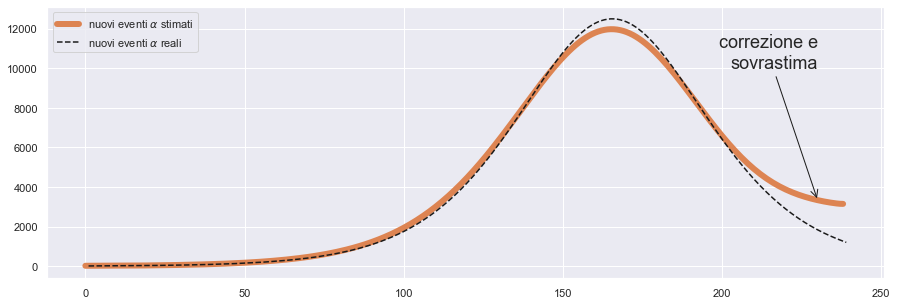

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_cor'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati', color='C1', lw=6)
ax.plot(X[1:], np.diff(Y), color='k', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'correzione e\nsovrastima',
    xy=(230, res1['d_alpha_cor'].mu[230]),
    xytext=(230, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

## Aggiustamento

Possiamo perciò ottenere un'aggiustamento $n(\alpha_{t_0})_{\mathrm{adj}}$ della sovrastima dovuta alla correzione, prendendo la media degli stimati grezzi $n(\alpha_{t_0})_{\mathrm{raw}}$ e corretti $n(\alpha_{t_0})_{\mathrm{cor}}$

$$
n(\alpha_{t_0})_{\mathrm{raw}} = 
\sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
\frac{
    \mathbf{PDF}[\omega]_{t_0+\tau}
}{
    \mathbf{CDF}[\omega]_{T-t_0}
}
$$

$$
n(\alpha_{t_0})_{\mathrm{cor}} = 
\sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
    \mathbf{PDF}[\omega]_{t_0+\tau}
$$

$$
n(\alpha_{t_0})_{\mathrm{adj}} = 
\frac{
n(\alpha_{t_0})_{\mathrm{raw}}
+
n(\alpha_{t_0})_{\mathrm{cor}}
}{2}
$$

In [29]:
_ = """$$
n(\alpha_{t_0})_{\mathrm{adj}} = \frac{1}{2}
\left[
\frac{1}{\mathbf{CDF}[\omega]_{T-t_0}}+1
\right]
\sum_{\tau=1}^{T} 
\frac{
    n(\omega_{t_0+\tau})
}{
    \mathrm{A}\Omega\mathrm{R}
}
    \mathbf{PDF}[\omega]_{t_0+\tau}
$$"""

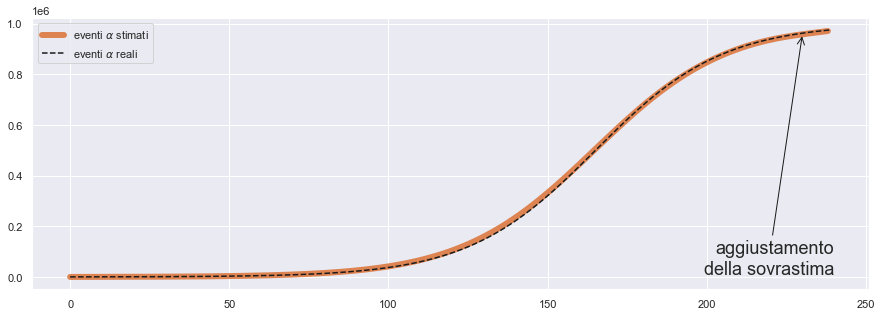

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['c_alpha_adj'].mu.plot(ax=ax, label=r'eventi $\alpha$ stimati', color='C1', lw=6)
ax.plot(X, Y, color='k', ls='--', label=r'eventi $\alpha$ reali')
ax.annotate(
    'aggiustamento\ndella sovrastima',
    xy=(230, res1['c_alpha_adj'].mu[230]),
    xytext=(240, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

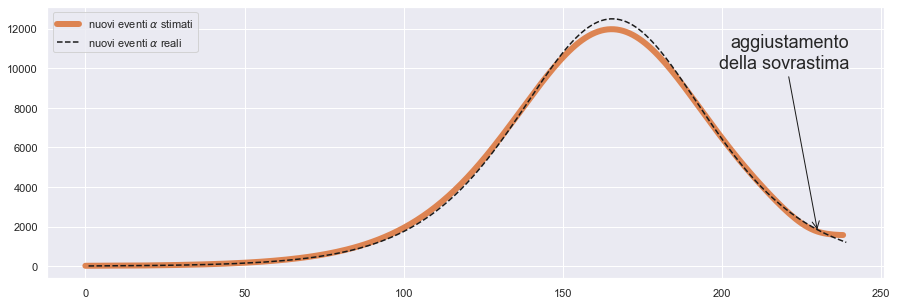

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
res1['d_alpha_adj'].mu.plot(ax=ax, label=r'nuovi eventi $\alpha$ stimati', color='C1', lw=6)
ax.plot(X[1:], np.diff(Y), color='k', ls='--', label=r'nuovi eventi $\alpha$ reali')
ax.annotate(
    'aggiustamento\ndella sovrastima',
    xy=(230, res1['d_alpha_adj'].mu[230]),
    xytext=(240, 10000),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)
ax.legend(loc='upper left')
plt.show()

## COVID-19 in Italia

Se definiamo

- $\alpha$: infezione da SARS-CoV-2
- $\omega$: decesso per COVID-19
- $\mathrm{A}\Omega\mathrm{R}$: Infection Fatality Rate $\mathrm{IFR}$ per COVID-19
- $\mathbf{PDF}[\omega]$: distribuzione di probabilità del tempo dall'infezione all'eventuale decesso per COVID-19

data l'osservazione dei decessi giornalieri per COVID-19 possiamo stimare le infezioni occorse precedentemente.

I dati dei decessi e dei casi osservati dal repository GitHub COVID-19 del [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19).

L'IFR stimato per l'Italia è tratto da Imperial College Report 34 [Brazeau, Verity et al. 2020](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-34-IFR/) (tabella pag 9).

I parametri per la distribuzione dell'intervallo dall'infezione al decesso sono tratti da [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909) e [Flaxman et al. 2020](https://doi.org/10.1101/2020.04.13.20064519).

Sappiamo dunque che:

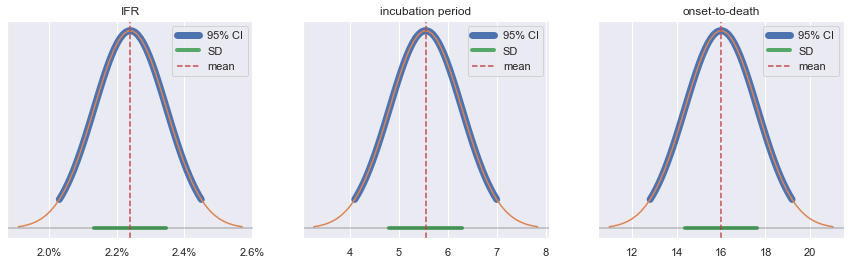

In [32]:
par_df2a, PDFs2a, CDFs2a, xDF2a = define_parameters(
    n_dfat[:400].size,
    ci=.95, plot_params=True
)

In [60]:
ifr_df2a = par_df2a[['IFR']].copy(deep=True)
ifr_df2a.index = ['2.5%', 'mean', '97.5%']
ifr_df2a.style.format(formatter="{:.2%}").set_caption("IFR values (Imperial College)")

,IFR
2.5%,2.03%
mean,2.24%
97.5%,2.45%


In [59]:
iod_df2a = par_df2a[['incub', 'onset']].copy(deep=True)
iod_df2a.columns = ['infection-to-onset', 'onset-to-death']
iod_df2a.index = ['2.5%', 'mean', '97.5%']
iod_df2a.style.format("{:.2f}").set_caption("infection-to-onset & onset-to-death values")

,infection-to-onset,onset-to-death
2.5%,4.10,12.80
mean,5.55,16.00
97.5%,7.00,19.20


Da questi parametri e conoscendo il coefficiente di variazione **cov** delle distribuzioni **Gamma** degli intervalli del tempo infection-to-onset $io$ (periodo d'incubazione) e del tempo onset-to-death $od$ (dai sintomi al decesso), possiamo facilmente calcolare i parametri di _shape_ e _scale_ della distribuzione **Gamma** dell'intervallo infection-to-death $id$ (dall'infezione al decesso).

Sappiamo infatti che

$$
\mathbf{cov} = \frac{\sigma}{\mu}
$$

$$
shape = \frac{\mu^2}{\sigma^2} = \frac{1}{\mathbf{cov}^2}
$$

$$
scale = \mu \cdot \mathbf{cov}^2
$$

Da [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909) e [Flaxman et al. 2020](https://doi.org/10.1101/2020.04.13.20064519) sappiamo che i coefficienti di variazione dell'intervallo infection-to-onset (periodo d'incubazione) $\mathbf{cov}_{io} = 0.86$ e dell'intervallo onset-to-death (dai sintomi al decesso) $\mathbf{cov}_{od} = 0.45$, da cui possiamo ricavare media la deviazione standard $\sigma$ dei due intervalli

$$
\sigma_{io} = \mu_{io} \cdot \mathbf{cov}_{io}
$$

$$
\sigma_{od} = \mu_{od} \cdot \mathbf{cov}_{od}
$$

Media e deviazione standard della convoluzione di due distribuzioni **Gamma** possono essere stimate come

$$
\mu_{1,2} = \mu_1 + \mu_2
$$

$$
\sigma_{1,2} = \sqrt{\sigma_1^2 + \sigma_2^2}
$$

Pertanto la distribuzione $\mathbf{Gamma}_{id}$ dell'intervalllo infection-to-death data dalla convoluzione delle distribuzioni $\mathbf{Gamma}_{io}$ infection-to-onset (periodo d'incubazione) e $\mathbf{Gamma}_{od}$ onset-to-death, sarà

$$
\mu_{id} = \mu_{io} + \mu_{od}
$$

$$
\sigma_{id} = \sqrt{\sigma_{io}^2 + \sigma_{od}^2}
$$

da cui possiamo ricavare il coefficiente di variazione $\mathbf{cov}_{id}$ dell'intervallo infection-to-death

$$
\mathbf{cov}_{id} = \frac{\sigma_{id}}{\mu_{id}}
$$

e infine i parametri _shape_ e _scale_ dell'intervallo infection-to-death

$$
shape_{id} = \frac{1}{\mathbf{cov}_{id}}
$$

$$
scale_{id} = \mu_{id} \cdot \mathbf{cov}_{id}^2
$$

Pertanto, la distribuzione $\mathbf{PDF}[\omega]$ per l'intervallo infection-to-death risulta

$$
\mathbf{Gamma}
\left(
    \alpha = \frac{1}{\mathbf{cov}_{id}}
    \;,\;
    \beta = \mu_{id} \cdot \mathbf{cov}_{id}^2
\right)
$$

Calcoleremo tre distribuzioni possibili

- per l'intervallo CI 2.5% di infection-to-onset e onset-to-death
- per la media di infection-to-onset e onset-to-death
- per l'intervallo CI 97.5% di infection-to-onset e onset-to-death

e li combineremo con tre valori di IFR

- CI 2.5% di IFR
- media di IFR
- CI 97.5% di IFR

in modo da ottenere una matrice di nove possibili stime

In [35]:
pd.DataFrame({
    'id 2.5%': [1, 2, 3],
    'id mean': [4, 5, 6],
    'id 97.5%': [7, 8, 9],
}, index=['IFR 2.5%', 'IFR mean', 'IFR 97.%']).style.set_caption("Backcasting parameters matrix")

,id 2.5%,id mean,id 97.5%
IFR 2.5%,1,4,7
IFR mean,2,5,8
IFR 97.%,3,6,9


da cui stimeremo mediana e intervallo di confidenza al 95%.

Con i valori sopra definiti, otteniamo i seguenti parametri per la distribuzione **Gamma** dell'intervallo infection-to-death

In [36]:
t_df2a = par_df2a[['alpha', 'beta']].copy(deep=True)
t_df2a.columns = ['shape', 'scale']
t_df2a.index = ['2.5%', 'mean', '97.5%']
t_df2a.style.set_caption("infection-to-death<br>Gamma parameters")

,shape,scale
2.5%,6.261966,2.698833
mean,6.223439,3.462716
97.5%,6.190279,4.232443


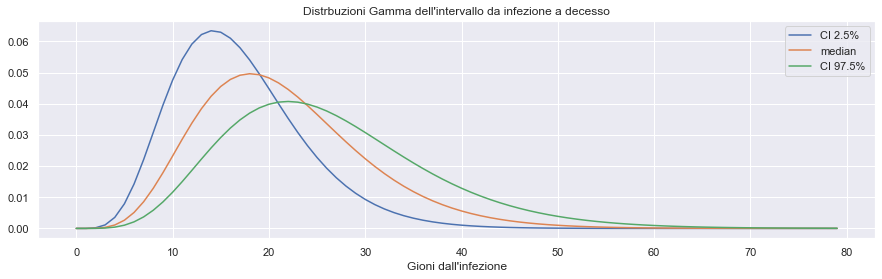

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(xDF2a[:80], PDFs2a[0,:80], label='CI 2.5%')
ax.plot(xDF2a[:80], PDFs2a[1,:80], label='median')
ax.plot(xDF2a[:80], PDFs2a[2,:80], label='CI 97.5%')
ax.set(
    title="Distrbuzioni Gamma dell'intervallo da infezione a decesso",
    xlabel="Gioni dall'infezione"
)
ax.legend()
plt.show()

In [38]:
res2a = backcasting(
    n_dfat[:400], par_df2a.IFR.values, PDFs2a, CDFs2a, DF.index[:400],
)

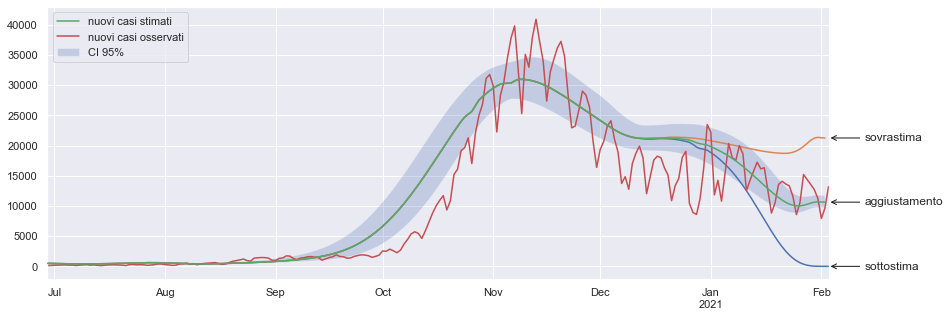

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
res2a['d_alpha_raw'].mu.plot(ax=ax, label='')
res2a['d_alpha_cor'].mu.plot(ax=ax, label='')
res2a['d_alpha_adj'].mu.plot(ax=ax, zorder=100, label='nuovi casi stimati')
ax.fill_between(
    res2a['d_alpha_adj'].index,
    res2a['d_alpha_adj'].lo, res2a['d_alpha_adj'].hi,
    alpha=.25, label='CI 95%'
)
DF.iloc[:400].plot(y='nuovi_positivi', ax=ax, label='nuovi casi osservati')

ax.annotate(
    'sovrastima',
    xy=(DF.index[399], res2a['d_alpha_cor'].mu.values[-1]),
    xytext=(DF.index[399]+pd.Timedelta(days=10), res2a['d_alpha_cor'].mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.annotate(
    'sottostima',
    xy=(DF.index[399], res2a['d_alpha_raw'].mu.values[-1]),
    xytext=(DF.index[399]+pd.Timedelta(days=10), res2a['d_alpha_raw'].mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.annotate(
    'aggiustamento',
    xy=(DF.index[399], res2a['d_alpha_adj'].dropna().mu.values[-1]),
    xytext=(DF.index[399]+pd.Timedelta(days=10), res2a['d_alpha_adj'].dropna().mu.values[-1]),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=12, ha='left', va='center'
)
ax.set(
    xlim=(DF.index[30*6], ax.get_xlim()[1])
)
ax.legend(loc='upper left')
plt.show()

## Confronto con Monte Carlo

Confrontiamo dunque i risultati dell'algoritmo di backcasting veloce implementato da EpiData.it con le simulazioni Monte Carlo dell'implementazione di [Phipps et al. 2020](https://doi.org/10.1098/rsos.200909).

In [40]:
phipps_data = pd.read_csv(
    'italy_dcases_ddeaths_20200914.csv',
    header=None
)

In [41]:
phipps_data.columns = ['dcases', 'ddeaths']

In [42]:
_ = """fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(phipps_data.ddeaths.values[2:], lw=3)
ax.plot(DF.nuovi_deceduti.values[:259], marker='.', ls='none')"""

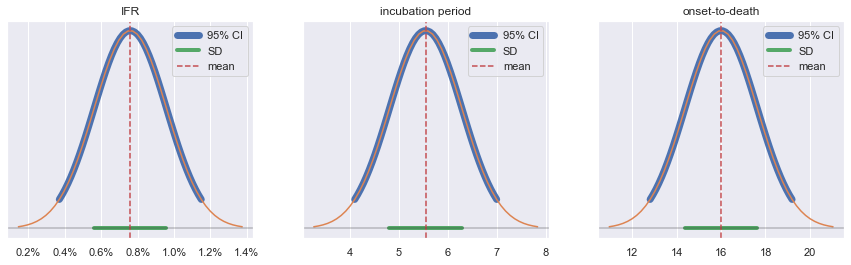

In [43]:
par_df3, PDFs3, CDFs3, xDF3 = define_parameters(
    phipps_data.index.size,
    dt_incub_lo = 4.1,
    dt_incub_hi = 7.0,
    dt_onset_lo = 12.8,
    dt_onset_hi = 19.2,
    ifr_lo = 0.0037,
    ifr_hi = 0.0115,
    ci=.95, plot_params=True
)

In [58]:
t_df3 = par_df3[['IFR',]].copy(deep=True)
t_df3.index = ['2.5%', 'mean', '97.5%']
t_df3.style.format(formatter="{:.2%}").set_caption("IFR values (Phipps et al.)")

,IFR
2.5%,0.37%
mean,0.76%
97.5%,1.15%


La distribuzione **Gamma** dell'intervallo da infezione a decesso è il medesimo utilizzato sopra.

L'IFR generico usato nel lavoro di Phipps et al è invece molto minore rispetto a quello usato da noi e stimato dall'Imperial College per l'Italia: differenti nazioni hanno verosimilmente differenti IFR dovuti soprattutto alla distribuzione delle fascie d'età nella popolazione. L'Italia è nazione piuttosto "anziana" ed ha pertanto un IFR verosimilmente più elevato rispetto a nazioni più "giovani".

Per questo motivo, non confronteremo i risultati delle due stime con i casi osservati ma solamente tra loro per verificare che il metodo di stima di EpiData.it dia risultati sovrapponibili alle simulazioni Monte Carlo di Phipps et al. (casi dal 1 Gennaio 2020 al 14 Settembre 2020).

In [45]:
dt_start = dt.datetime.now()

In [46]:
res3 = backcasting(
    phipps_data.ddeaths.values, par_df3.IFR.values, PDFs3, CDFs3, phipps_data.index,
)

In [47]:
dt_end = dt.datetime.now()

Si noti che l'implementazione di Phipps et al. con metodo Monte Carlo comporta 10'000 simulazioni che, in un normale personal computer, prendono qualche ora di tempo per una serie temporale come quella di COVID-19.

L'algoritmo implementato qui e visualizzabile su GitHub (come tutto il sito EpiData.it) all'indirizzo [Real_infected](https://github.com/maxdevblock/covid-19-website/blob/master/Italia/Real_infected.ipynb) è stato eseguito in:

In [48]:
dt_delta = dt_end - dt_start
print('Eseguito in', dt_delta)

Eseguito in 0:00:00.083928


In [49]:
phipps = pd.read_csv(
    'cumulative_infections_v9_italy_20200914.txt',
    index_col='day0'
)

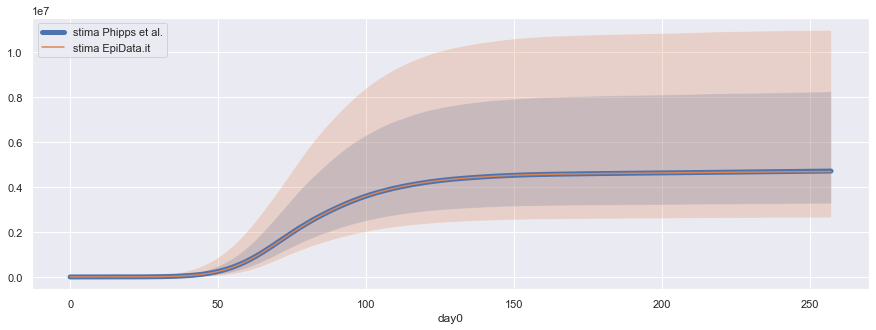

In [50]:
ax = phipps[:-1].plot(y='n_inf_median', lw=5, figsize=(15, 5), label='stima Phipps et al.')
ax.fill_between(
    phipps.index[:-1],
    phipps.n_inf_02p5[:-1], phipps.n_inf_97p5[:-1],
    alpha=.25
)

ax.plot(res3['c_alpha_adj'].mu.values, label='stima EpiData.it')
ax.fill_between(
    res3['c_alpha_adj'].index,
    res3['c_alpha_adj'].lo.values, res3['c_alpha_adj'].hi.values,
    alpha=.25
)
ax.legend(loc='upper left')
plt.show()

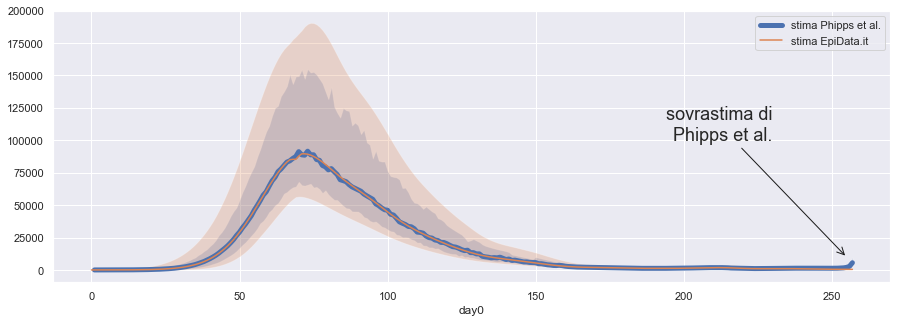

In [51]:
ax = phipps[:-1].diff().plot(y='n_inf_median', lw=5, figsize=(15, 5), label='stima Phipps et al.')
ax.fill_between(
    phipps.index[:-1],
    phipps.n_inf_02p5[:-1].diff(), phipps.n_inf_97p5[:-1].diff(),
    alpha=.25
)
res3['d_alpha_adj'].mu.plot(ax=ax, label='stima EpiData.it')
ax.fill_between(
    res3['d_alpha_adj'].index,
    res3['d_alpha_adj'].lo.values, res3['d_alpha_adj'].hi.values,
    alpha=.25
)
ax.annotate(
    'sovrastima di\nPhipps et al.',
    xy=(255, 1e4),
    xytext=(230, 1e5),
    arrowprops=dict(color='k', arrowstyle='->'),
    fontsize=18, ha='right'
)

ax.legend()
plt.show()

In [52]:
con_mod = sm.OLS.from_formula('EpiData ~ Phipps + 0', data=pd.DataFrame({
    'Phipps': phipps.n_inf_median.values[:-1],
    'EpiData': res3['c_alpha_adj'].mu.values,
})).fit()

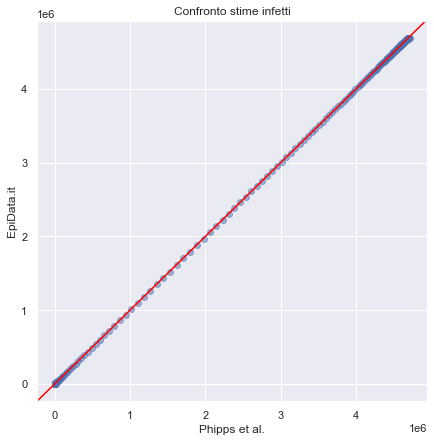

In [53]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    phipps.n_inf_median.values[:-1],
    res3['c_alpha_adj'].mu.values,
    alpha=.5
)
ax.axline(xy1=[0, 0], slope=1, color='red')
ax.set(
    xlabel='Phipps et al.',
    ylabel='EpiData.it',
    title='Confronto stime infetti'
)
plt.show()

In [54]:
con_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                EpiData   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.960e+08
Date:                Tue, 09 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:33:11   Log-Likelihood:                         -2464.3
No. Observations:                 258   AIC:                                      4931.
Df Residuals:                     257   BIC:                                      4934.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Phipps         1.0000   5.81e-05   1.72e+04      0.000       1.000       1.000
==============================================================================
Omnibus:                      164.909   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.008
Skew:                          -2.609   Prob(JB):                    1.04e-248
Kurtosis:                      11.888   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""